In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!/opt/bin/nvidia-smi

Mon Apr 24 06:50:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.__version__

'2.0.0+cu118'

In [ ]:
!unzip "/content/drive/MyDrive/101_ObjectCategories.zip" -d "/content"

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/101_ObjectCategories/Faces_easy/image_0241.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0242.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0243.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0244.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0245.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0246.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0247.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0248.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0249.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0250.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0251.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0252.jpg  
  inflating: /content/101_ObjectCategories/Faces_easy/image_0253.jpg  
  inflating: /content/101_ObjectCategories/Faces_e

In [ ]:
import torch
print("CUDA available: ", torch.cuda.is_available())
print("CUDA device count: ", torch.cuda.device_count())


CUDA available:  True
CUDA device count:  1


# 读取数据集

In [ ]:
import torchvision.datasets as dataset
import cv2
import numpy as np

data_dir = '/content/101_ObjectCategories'
data = dataset.ImageFolder(data_dir)

# print(data.classes)
# print(data.class_to_idx)
# print(data.imgs)

imgs = []
labels = []
for img_path in data.imgs:
    # images
    img = cv2.imread(img_path[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #将BGR转化为RGB
    img = cv2.resize(img, (224, 224)) # size变成224*224
    imgs.append(img)
    # labels
    labels.append(img_path[1])
imgs = np.array(imgs)
labels = np.array(labels)



In [ ]:
imgs.shape

(8677, 224, 224, 3)

# 分出训练集，验证集, 测试集

In [ ]:
from torchvision.transforms import transforms

train_transform = transforms.Compose([
    transforms.ToPILImage(),

    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),  # 随机垂直翻转
    transforms.RandomRotation(20),  # 随机旋转（-20°到20°之间）
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.3333)),  # 随机裁剪和缩放
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 随机调整亮度、对比度、饱和度和色调

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
     ])

test_transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
     ])

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return (len(self.images))

    def __getitem__(self, idx):

        if self.transforms:
            img = self.transforms(self.images[idx])

        return (img, self.labels[idx])

In [ ]:
# 按类随机抽取

In [ ]:
import numpy as np

def stratified_split(images, labels, train_ratio=0.7, test_ratio=0.15):
    unique_labels = np.unique(labels)
    train_indices = []
    val_indices = []
    test_indices = []

    # 每次输出同样的值
    np.random.seed(16)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        np.random.shuffle(label_indices)

        label_train_size = int(len(label_indices) * train_ratio)
        label_test_size = int(len(label_indices) * test_ratio)

        train_indices.extend(label_indices[:label_train_size])
        test_indices.extend(label_indices[label_train_size : label_train_size + label_test_size])
        val_indices.extend(label_indices[label_train_size + label_test_size :])

    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    np.random.shuffle(val_indices)

    return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = stratified_split(imgs, labels)

train_dataset = MyDataset(imgs[train_indices], labels[train_indices], train_transform)
test_dataset = MyDataset(imgs[test_indices], labels[test_indices], test_transform)
val_dataset = MyDataset(imgs[val_indices], labels[val_indices], test_transform)

from torch.utils.data import DataLoader

batch_size = 8
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)


In [ ]:
# 权重采样

import torch
from torch.utils.data import WeightedRandomSampler

# 计算每个类别的权重
class_counts = np.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts
sample_weights = class_weights[train_dataset.labels]

# 创建 WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# 使用 WeightedRandomSampler 创建训练集的数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, pin_memory=True)


In [ ]:
# mixup

import numpy as np

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [ ]:
# EMA
class EMA:
    def __init__(self, model, decay):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.backup[name] = param.data
                param.data = self.shadow[name]

    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}


# model

In [ ]:
"""
original code from facebook research:
https://github.com/facebookresearch/ConvNeXt
"""

import torch
import torch.nn as nn
import torch.nn.functional as F


def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """

    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape), requires_grad=True)
        self.bias = nn.Parameter(torch.zeros(normalized_shape), requires_grad=True)
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise ValueError(f"not support data format '{self.data_format}'")
        self.normalized_shape = (normalized_shape,)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            # [batch_size, channels, height, width]
            mean = x.mean(1, keepdim=True)
            var = (x - mean).pow(2).mean(1, keepdim=True)
            x = (x - mean) / torch.sqrt(var + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    Args:
        dim (int): Number of input channels.
        drop_rate (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_rate=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6, data_format="channels_last")
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim,)),
                                  requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_rate) if drop_rate > 0. else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # [N, C, H, W] -> [N, H, W, C]
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # [N, H, W, C] -> [N, C, H, W]

        x = shortcut + self.drop_path(x)
        return x


class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans: int = 3, num_classes: int = 1000, depths: list = None,
                 dims: list = None, drop_path_rate: float = 0., layer_scale_init_value: float = 1e-6,
                 head_init_scale: float = 1.):
        super().__init__()
        self.downsample_layers = nn.ModuleList()  # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
                             LayerNorm(dims[0], eps=1e-6, data_format="channels_first"))
        self.downsample_layers.append(stem)

        # 对应stage2-stage4前的3个downsample
        for i in range(3):
            downsample_layer = nn.Sequential(LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                                             nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2))
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList()  # 4 feature resolution stages, each consisting of multiple blocks
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0
        # 构建每个stage中堆叠的block
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_rate=dp_rates[cur + j], layer_scale_init_value=layer_scale_init_value)
                  for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=0.2)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        return self.norm(x.mean([-2, -1]))  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        x = self.head(x)
        return x


def convnext_tiny(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth
    model = ConvNeXt(depths=[3, 3, 9, 3],
                     dims=[96, 192, 384, 768],
                     num_classes=num_classes)
    return model


def convnext_small(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[96, 192, 384, 768],
                     num_classes=num_classes)
    return model


def convnext_base(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth
    # https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[128, 256, 512, 1024],
                     num_classes=num_classes)
    return model


def convnext_large(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth
    # https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[192, 384, 768, 1536],
                     num_classes=num_classes)
    return model


def convnext_xlarge(num_classes: int):
    # https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth
    model = ConvNeXt(depths=[3, 3, 27, 3],
                     dims=[256, 512, 1024, 2048],
                     num_classes=num_classes)
    return model

# val 和 test

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

def val():
    model.eval()
    total_loss = 0.0
    step = 0

    # 使用 EMA 参数
    ema.apply_shadow()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            step += 1
            data, label = data.to(device), label.to(device)
            label = label.to(torch.int64)  # 类型转换

            optimizer.zero_grad()
            outputs = model(data)  # torch.Size([batch_size, 101])
            loss = F.cross_entropy(outputs, label)

            total_loss += loss.item()

            # Store true and predicted labels for each batch
            true_labels.extend(label.cpu().numpy())
            pred_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # 恢复原始参数
    ema.restore()

    # Calculate metrics
    val_acc = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    val_recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    val_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    val_ck = cohen_kappa_score(true_labels, pred_labels)
    val_mcc = matthews_corrcoef(true_labels, pred_labels)

    total_epoch_val_loss = total_loss
    avg_val_loss = total_loss / len(val_loader)

    return val_acc, val_precision, val_recall, val_f1, total_epoch_val_loss, avg_val_loss, val_ck, val_mcc

# val()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def test():
    model.eval()
    total_loss = 0.0
    step = 0

    # 使用 EMA 参数
    ema.apply_shadow()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            step += 1
            data, label = data.to(device), label.to(device)
            label = label.to(torch.int64)  # 类型转换

            optimizer.zero_grad()
            outputs = model(data)  # torch.Size([batch_size, 101])
            loss = F.cross_entropy(outputs, label)

            total_loss += loss.item()

            # Store true and predicted labels for each batch
            true_labels.extend(label.cpu().numpy())
            pred_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # 恢复原始参数
    ema.restore()

    # Calculate metrics
    test_acc = accuracy_score(true_labels, pred_labels)
    test_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_ck = cohen_kappa_score(true_labels, pred_labels)
    test_mcc = matthews_corrcoef(true_labels, pred_labels)

    total_epoch_test_loss = total_loss
    avg_test_loss = total_loss / len(test_loader)

    return test_acc, test_precision, test_recall, test_f1, total_epoch_test_loss, avg_test_loss, test_ck, test_mcc

# test()


# 加载模型

In [ ]:

# model_path = '/content/drive/MyDrive/586/ConvNeXt/图像增强mixup+分组权重衰减/my_model_60.pt'

# # 从文件中加载模型状态字典
# model_state_dict = torch.load(model_path)

# # 创建新的模型实例
# model = convnext_tiny(101)

# # 将加载的模型状态字典应用于新的模型实例
# model.load_state_dict(model_state_dict)


# 训练

In [ ]:
# 参数

import torch.optim as optim

epochs = 150

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create model
model = convnext_tiny(num_classes = 101).to(device)

# load model
# model_path = '/content/drive/MyDrive/586/ConvNeXt/图像增强mixup+分组权重衰减/my_model_60.pt'
# model_state_dict = torch.load(model_path)
# model = convnext_tiny(101).to(device)
# model.load_state_dict(model_state_dict)

criterion = nn.CrossEntropyLoss()  # 交叉熵损失

# EMA
ema = EMA(model, decay=0.999)
ema.register()

# 参数分组L2正则。
# 哪些参数要L2正则，哪些不需要
# pg = [p for p in model.parameters() if p.requires_grad]
def get_params_groups(model: torch.nn.Module, weight_decay: float = 1e-5):
    # 记录optimize要训练的权重参数
    parameter_group_vars = {"decay": {"params": [], "weight_decay": weight_decay},
                            "no_decay": {"params": [], "weight_decay": 0.}}

    # 记录对应的权重名称
    parameter_group_names = {"decay": {"params": [], "weight_decay": weight_decay},
                             "no_decay": {"params": [], "weight_decay": 0.}}

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights

        if len(param.shape) == 1 or name.endswith(".bias"):
            group_name = "no_decay"
        else:
            group_name = "decay"

        parameter_group_vars[group_name]["params"].append(param)
        parameter_group_names[group_name]["params"].append(name)

    return list(parameter_group_vars.values())

pg = get_params_groups(model, weight_decay=5e-2) # 参数列表
optimizer = optim.AdamW(pg, lr=0.002, weight_decay=5e-2)

In [ ]:
# warmup + 余弦退火

import math

def create_lr_scheduler(optimizer,
                        num_step: int,
                        epochs: int,
                        warmup=True,
                        warmup_epochs=1,
                        warmup_factor=1e-3,
                        end_factor=1e-6):
    assert num_step > 0 and epochs > 0
    if warmup is False:
        warmup_epochs = 0

    def f(x):
        """
        根据step数返回一个学习率倍率因子，
        注意在训练开始之前，pytorch会提前调用一次lr_scheduler.step()方法
        """
        if warmup is True and x <= (warmup_epochs * num_step):
            alpha = float(x) / (warmup_epochs * num_step)
            # warmup过程中lr倍率因子从warmup_factor -> 1
            return warmup_factor * (1 - alpha) + alpha
        else:
            current_step = (x - warmup_epochs * num_step)
            cosine_steps = (epochs - warmup_epochs) * num_step
            # warmup后lr倍率因子从1 -> end_factor
            return ((1 + math.cos(current_step * math.pi / cosine_steps)) / 2) * (1 - end_factor) + end_factor

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=f)

lr_scheduler = create_lr_scheduler(optimizer, len(train_loader), epochs, warmup=False, warmup_epochs=0)

In [ ]:
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#训练过程
def train():
    model.train()

    total_loss = 0.0
    total_num_correct = 0
    step = 0


    # 用于存储预测和真实标签的列表
    # true_labels = []
    # pred_labels = []

    for batch_idx, (data, label) in enumerate(train_loader):

        step += 1

        data, label = data.to(device), label.to(device)
        label = label.to(torch.int64)  #类型转换

        # Apply mixup
        inputs, targets_a, targets_b, lam = mixup_data(data, label)

        # reset grad
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)   #torch.Size([batch_size, 101]),101个概率
        loss_a = F.cross_entropy(outputs, targets_a)
        loss_b = F.cross_entropy(outputs, targets_b)
        loss = lam * loss_a + (1 - lam) * loss_b


        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # 更新 EMA
        ema.update()

        total_loss += loss.item()


    total_epoch_train_loss = total_loss
    avg_train_loss = total_loss / len(train_loader)


    return total_epoch_train_loss, avg_train_loss



In [ ]:
# train_accs = []
# train_precisions = []
# train_recalls = []
# train_f1s = []
total_train_losses = []
avg_train_losses = []
# train_cks = []
# train_mccs = []

val_accs = []
val_precisions = []
val_recalls = []
val_f1s = []
total_val_losses = []
avg_val_losses = []
val_cks = []
val_mccs = []

test_accs = []
test_precisions = []
test_recalls = []
test_f1s = []
total_test_losses = []
avg_test_losses = []
test_cks = []
test_mccs = []

def run():

    print('start training')
    for epoch in range(epochs):

        # train_acc, train_precision, train_recall, train_f1, total_epoch_train_loss, avg_train_loss, train_ck, train_mcc = train()
        total_epoch_train_loss, avg_train_loss = train()
        # train_accs.append(train_acc)
        # train_precisions.append(train_precision)
        # train_recalls.append(train_recall)
        # train_f1s.append(train_f1)
        total_train_losses.append(total_epoch_train_loss)
        avg_train_losses.append(avg_train_loss)
        # train_cks.append(train_ck)
        # train_mccs.append(train_mcc)

        val_acc, val_precision, val_recall, val_f1, total_epoch_val_loss, avg_val_loss, val_ck, val_mcc = val()
        val_accs.append(val_acc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        total_val_losses.append(total_epoch_val_loss)
        avg_val_losses.append(avg_val_loss)
        val_cks.append(val_ck)
        val_mccs.append(val_mcc)

        test_acc, test_precision, test_recall, test_f1, total_epoch_test_loss, avg_test_loss, test_ck, test_mcc = test()
        test_accs.append(test_acc)
        test_precisions.append(test_precision)
        test_recalls.append(test_recall)
        test_f1s.append(test_f1)
        total_test_losses.append(total_epoch_test_loss)
        avg_test_losses.append(avg_test_loss)
        test_cks.append(test_ck)
        test_mccs.append(test_mcc)

        # 更新学习率
        lr_scheduler.step()

        # 每30epoch保存一次model
        import torch
        if (epoch+1)%30 == 0:
          model_path = '/content/drive/MyDrive/586/ConvNeXt/按类抽取_图像增强mixup权重采样+EMA+分组权重衰减+warmup余弦+小batch/my_model_' + str(epoch+1) + '.pt'
          torch.save(model.state_dict(), model_path)


        print("EPOCH [{}/{}] Train avg loss = {:.4f}, Val acc = {:.4f} Val avg loss = {:.4f}, Test acc = {:.4f} Test avg loss = {:.4f}".format(epoch+1, epochs,
                                                        # train_acc,
                                                        avg_train_loss,
                                                        val_acc, avg_val_loss,
                                                        test_acc, avg_test_loss,
                                                        ))

run()

start training
EPOCH [1/150] Train avg loss = 5.6067, Val acc = 0.0280 Val avg loss = 5.6745, Test acc = 0.0279 Test avg loss = 5.6906
EPOCH [2/150] Train avg loss = 4.5595, Val acc = 0.0394 Val avg loss = 4.6595, Test acc = 0.0342 Test avg loss = 4.6669
EPOCH [3/150] Train avg loss = 4.4997, Val acc = 0.0394 Val avg loss = 4.4529, Test acc = 0.0366 Test avg loss = 4.4532
EPOCH [4/150] Train avg loss = 4.4594, Val acc = 0.0495 Val avg loss = 4.3450, Test acc = 0.0470 Test avg loss = 4.3510
EPOCH [5/150] Train avg loss = 4.3824, Val acc = 0.0681 Val avg loss = 4.2344, Test acc = 0.0693 Test avg loss = 4.2423
EPOCH [6/150] Train avg loss = 4.2940, Val acc = 0.0932 Val avg loss = 4.0842, Test acc = 0.0939 Test avg loss = 4.0861
EPOCH [7/150] Train avg loss = 4.2193, Val acc = 0.1498 Val avg loss = 3.9112, Test acc = 0.1616 Test avg loss = 3.8983
EPOCH [8/150] Train avg loss = 4.1288, Val acc = 0.1978 Val avg loss = 3.7193, Test acc = 0.2158 Test avg loss = 3.6986
EPOCH [9/150] Train avg l

# acc plot

In [ ]:
import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_accs)+1), 'y': train_accs, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_accs)+1), 'y': val_accs, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_accs)+1), 'y': test_accs, 'source': 'Test'})
])


# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='acc'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart


alt.Chart(...)

# precisions

In [ ]:


import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_precisions)+1), 'y': train_precisions, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_precisions)+1), 'y': val_precisions, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_precisions)+1), 'y': test_precisions, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='precisions'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart

alt.Chart(...)

# recalls

In [ ]:


import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_recalls)+1), 'y': train_precisions, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_recalls)+1), 'y': val_recalls, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_recalls)+1), 'y': test_recalls, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='recalls'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart

alt.Chart(...)

# f1

In [ ]:


import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_f1s)+1), 'y': train_f1s, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_f1s)+1), 'y': val_f1s, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_f1s)+1), 'y': test_f1s, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='recalls'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart

alt.Chart(...)

# avg loss

In [ ]:


import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    pd.DataFrame({'x': range(1, len(avg_train_losses)+1), 'y': avg_train_losses, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(avg_val_losses)+1), 'y': avg_val_losses, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(avg_test_losses)+1), 'y': avg_test_losses, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='avg loss'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart


alt.Chart(...)

# 组合 avgloss

In [ ]:
# avg_train_losses60_120 = avg_train_losses
# avg_val_losses60_120 = avg_val_losses
# avg_test_losses60_120 = avg_test_losses

In [ ]:
# import altair as alt
# import pandas as pd
# import json

# file_path = '/content/drive/MyDrive/586/ConvNeXt/图像增强mixup+分组权重衰减/metrics_60.json'

# def load_metrics(file_path):
#     with open(file_path, 'r') as f:
#         metrics_dict = json.load(f)
#     for metric_name, metric_value in metrics_dict.items():
#         globals()[metric_name] = metric_value

# load_metrics(file_path)

# avg_train_losses = avg_train_losses + avg_train_losses60_120
# avg_val_losses =  avg_val_losses + avg_val_losses60_120
# avg_test_losses = avg_test_losses + avg_test_losses60_120

# # Combine the data into a single dataframe with a 'source' column
# df = pd.concat([
#     pd.DataFrame({'x': range(1, len(avg_train_losses)+1), 'y': avg_train_losses, 'source': 'Train'}),
#     pd.DataFrame({'x': range(1, len(avg_val_losses)+1), 'y': avg_val_losses, 'source': 'Validation'}),
#     pd.DataFrame({'x': range(1, len(avg_test_losses)+1), 'y': avg_test_losses, 'source': 'Test'})
# ])

# # Create a chart with color encoding based on the 'source' column
# chart = alt.Chart(df).encode(
#     x=alt.X('x', title='epochs'),
#     y=alt.Y('y', title='avg loss'),
#     color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
# ).mark_line()

# chart


# total loss

In [ ]:


import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    pd.DataFrame({'x': range(1, len(total_train_losses)+1), 'y': total_train_losses, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(total_val_losses)+1), 'y': total_val_losses, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(total_test_losses)+1), 'y': total_test_losses, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='total loss'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart


alt.Chart(...)

# Cohen's Kappa score

In [ ]:
import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_cks)+1), 'y': train_cks, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_cks)+1), 'y': val_cks, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_cks)+1), 'y': test_cks, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='ck'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart

alt.Chart(...)

# Matthew's correlation coefficient（MCC）

In [ ]:
import altair as alt
import pandas as pd

# Combine the data into a single dataframe with a 'source' column
df = pd.concat([
    # pd.DataFrame({'x': range(1, len(train_mccs)+1), 'y': train_mccs, 'source': 'Train'}),
    pd.DataFrame({'x': range(1, len(val_mccs)+1), 'y': val_mccs, 'source': 'Validation'}),
    pd.DataFrame({'x': range(1, len(test_mccs)+1), 'y': test_mccs, 'source': 'Test'})
])

# Create a chart with color encoding based on the 'source' column
chart = alt.Chart(df).encode(
    x=alt.X('x', title='epochs'),
    y=alt.Y('y', title='mcc'),
    color=alt.Color('source', legend=alt.Legend(title = None, orient='bottom-right'))
).mark_line()

chart

alt.Chart(...)

# 混淆矩阵（Confusion Matrix）

In [ ]:
# from sklearn.metrics import cohen_kappa_score
# from sklearn.metrics import matthews_corrcoef

# matthews_corrcoef(true_labels, pred_labels)

# cohen_kappa_score(true_labels, pred_labels)

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# _, true_labels, pred_labels = final_val()

# cm = confusion_matrix(true_labels, pred_labels)

# cmp = ConfusionMatrixDisplay(cm)

# fig, ax = plt.subplots(figsize=(30,30))
# cmp.plot(ax=ax)

# 最终val和test

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def final_val():
    model.eval()
    total_loss = 0.0
    step = 0

    # 使用 EMA 参数
    ema.apply_shadow()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(val_loader):
            step += 1
            data, label = data.to(device), label.to(device)
            label = label.to(torch.int64)  # 类型转换

            optimizer.zero_grad()
            outputs = model(data)  # torch.Size([batch_size, 101])
            loss = F.cross_entropy(outputs, label)

            total_loss += loss.item()

            # Store true and predicted labels for each batch
            true_labels.extend(label.cpu().numpy())
            pred_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # 恢复原始参数
    ema.restore()

    # Calculate metrics
    val_acc = accuracy_score(true_labels, pred_labels)
    val_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    val_recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    val_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    total_val_loss = total_loss
    avg_val_loss = total_loss / len(val_loader)

    return (val_acc, val_precision, val_recall, val_f1, total_val_loss, avg_val_loss), true_labels, pred_labels

# final_val()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def final_test():
    model.eval()
    total_loss = 0.0
    step = 0

    # 使用 EMA 参数
    ema.apply_shadow()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            step += 1
            data, label = data.to(device), label.to(device)
            label = label.to(torch.int64)  # 类型转换

            optimizer.zero_grad()
            outputs = model(data)  # torch.Size([batch_size, 101])
            loss = F.cross_entropy(outputs, label)

            total_loss += loss.item()

            # Store true and predicted labels for each batch
            true_labels.extend(label.cpu().numpy())
            pred_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # 恢复原始参数
    ema.restore()

    # Calculate metrics
    test_acc = accuracy_score(true_labels, pred_labels)
    test_precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    test_f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    total_test_loss = total_loss
    avg_test_loss = total_loss / len(val_loader)

    return (test_acc, test_precision, test_recall, test_f1, total_test_loss, avg_test_loss), true_labels, pred_labels

# final_test()


# 最后分数

In [ ]:
# print('TRAIN f1={:.04} ck={:.04} mcc={:.04}'.format(train_f1s[len(train_f1s)-1], train_cks[len(train_cks)-1], train_mccs[len(train_mccs)-1]))

In [ ]:
print('VAL f1={:.04} ck={:.04} mcc={:.04}'.format(val_f1s[len(val_f1s)-1], val_cks[len(val_cks)-1], val_mccs[len(val_mccs)-1]))

VAL f1=0.8006 ck=0.8035 mcc=0.8037


In [ ]:
print('TEST f1={:.04} ck={:.04} mcc={:.04}'.format(test_f1s[len(test_f1s)-1], test_cks[len(test_cks)-1], test_mccs[len(test_mccs)-1]))

TEST f1=0.8349 ck=0.8334 mcc=0.8335


# 几个类别

In [ ]:
import torchvision.datasets as dataset
import cv2
import numpy as np

data_dir = '/content/101_ObjectCategories'
data = dataset.ImageFolder(data_dir)


labels_dic = {}
for i in range(101):
    labels_dic[i] = 0  # 可以将值初始化为None，也可以指定其他初始值


for img_path in data.imgs:
  idx = img_path[1]
  # print(img_path[0])
  labels_dic[idx] = labels_dic[idx]+1

labels_dic

data.class_to_idx

{'Faces': 0,
 'Faces_easy': 1,
 'Leopards': 2,
 'Motorbikes': 3,
 'accordion': 4,
 'airplanes': 5,
 'anchor': 6,
 'ant': 7,
 'barrel': 8,
 'bass': 9,
 'beaver': 10,
 'binocular': 11,
 'bonsai': 12,
 'brain': 13,
 'brontosaurus': 14,
 'buddha': 15,
 'butterfly': 16,
 'camera': 17,
 'cannon': 18,
 'car_side': 19,
 'ceiling_fan': 20,
 'cellphone': 21,
 'chair': 22,
 'chandelier': 23,
 'cougar_body': 24,
 'cougar_face': 25,
 'crab': 26,
 'crayfish': 27,
 'crocodile': 28,
 'crocodile_head': 29,
 'cup': 30,
 'dalmatian': 31,
 'dollar_bill': 32,
 'dolphin': 33,
 'dragonfly': 34,
 'electric_guitar': 35,
 'elephant': 36,
 'emu': 37,
 'euphonium': 38,
 'ewer': 39,
 'ferry': 40,
 'flamingo': 41,
 'flamingo_head': 42,
 'garfield': 43,
 'gerenuk': 44,
 'gramophone': 45,
 'grand_piano': 46,
 'hawksbill': 47,
 'headphone': 48,
 'hedgehog': 49,
 'helicopter': 50,
 'ibis': 51,
 'inline_skate': 52,
 'joshua_tree': 53,
 'kangaroo': 54,
 'ketch': 55,
 'lamp': 56,
 'laptop': 57,
 'llama': 58,
 'lobster': 5

# 保存数据

In [ ]:
# 要保存的列表
metrics_list = [
    # "train_accs",
    # "train_precisions",
    # "train_recalls",
    # "train_f1s",
    "total_train_losses",
    "avg_train_losses",
    # "train_cks",
    # "train_mccs",
    "val_accs",
    "val_precisions",
    "val_recalls",
    "val_f1s",
    "total_val_losses",
    "avg_val_losses",
    "val_cks",
    "val_mccs",
    "test_accs",
    "test_precisions",
    "test_recalls",
    "test_f1s",
    "total_test_losses",
    "avg_test_losses",
    "test_cks",
    "test_mccs",
]


import json

file_path = '/content/drive/MyDrive/586/ConvNeXt/按类抽取_图像增强mixup权重采样+EMA+分组权重衰减+warmup余弦+小batch/my_model.json'

def save_metrics(metrics_list, file_path):
    metrics_dict = {}
    for metric_name in metrics_list:
        metric_value = globals().get(metric_name)
        metrics_dict[metric_name] = metric_value
    with open(file_path, 'w') as f:
        json.dump(metrics_dict, f)


save_metrics(metrics_list, file_path)



In [ ]:
def load_metrics(file_path):
    with open(file_path, 'r') as f:
        metrics_dict = json.load(f)
    for metric_name, metric_value in metrics_dict.items():
        globals()[metric_name] = metric_value

load_metrics(file_path)


# 保存model

In [ ]:
import torch

model_path = model_path = '/content/drive/MyDrive/586/ConvNeXt/按类抽取_图像增强mixup权重采样+EMA+分组权重衰减+warmup余弦+小batch/my_model_' + str(epochs) + '.pt'


torch.save(model.state_dict(), model_path)


In [ ]:
import torch

model_path = model_path = '/content/drive/MyDrive/586/ConvNeXt/按类抽取_图像增强mixup权重采样+EMA+分组权重衰减+warmup余弦+小batch/my_model_' + str(150) + '.pt'

# 从文件中加载模型状态字典
model_state_dict = torch.load(model_path)

# 创建新的模型实例
model = convnext_tiny(101)

# 将加载的模型状态字典应用于新的模型实例
model.load_state_dict(model_state_dict)


<All keys matched successfully>

# 混淆矩阵

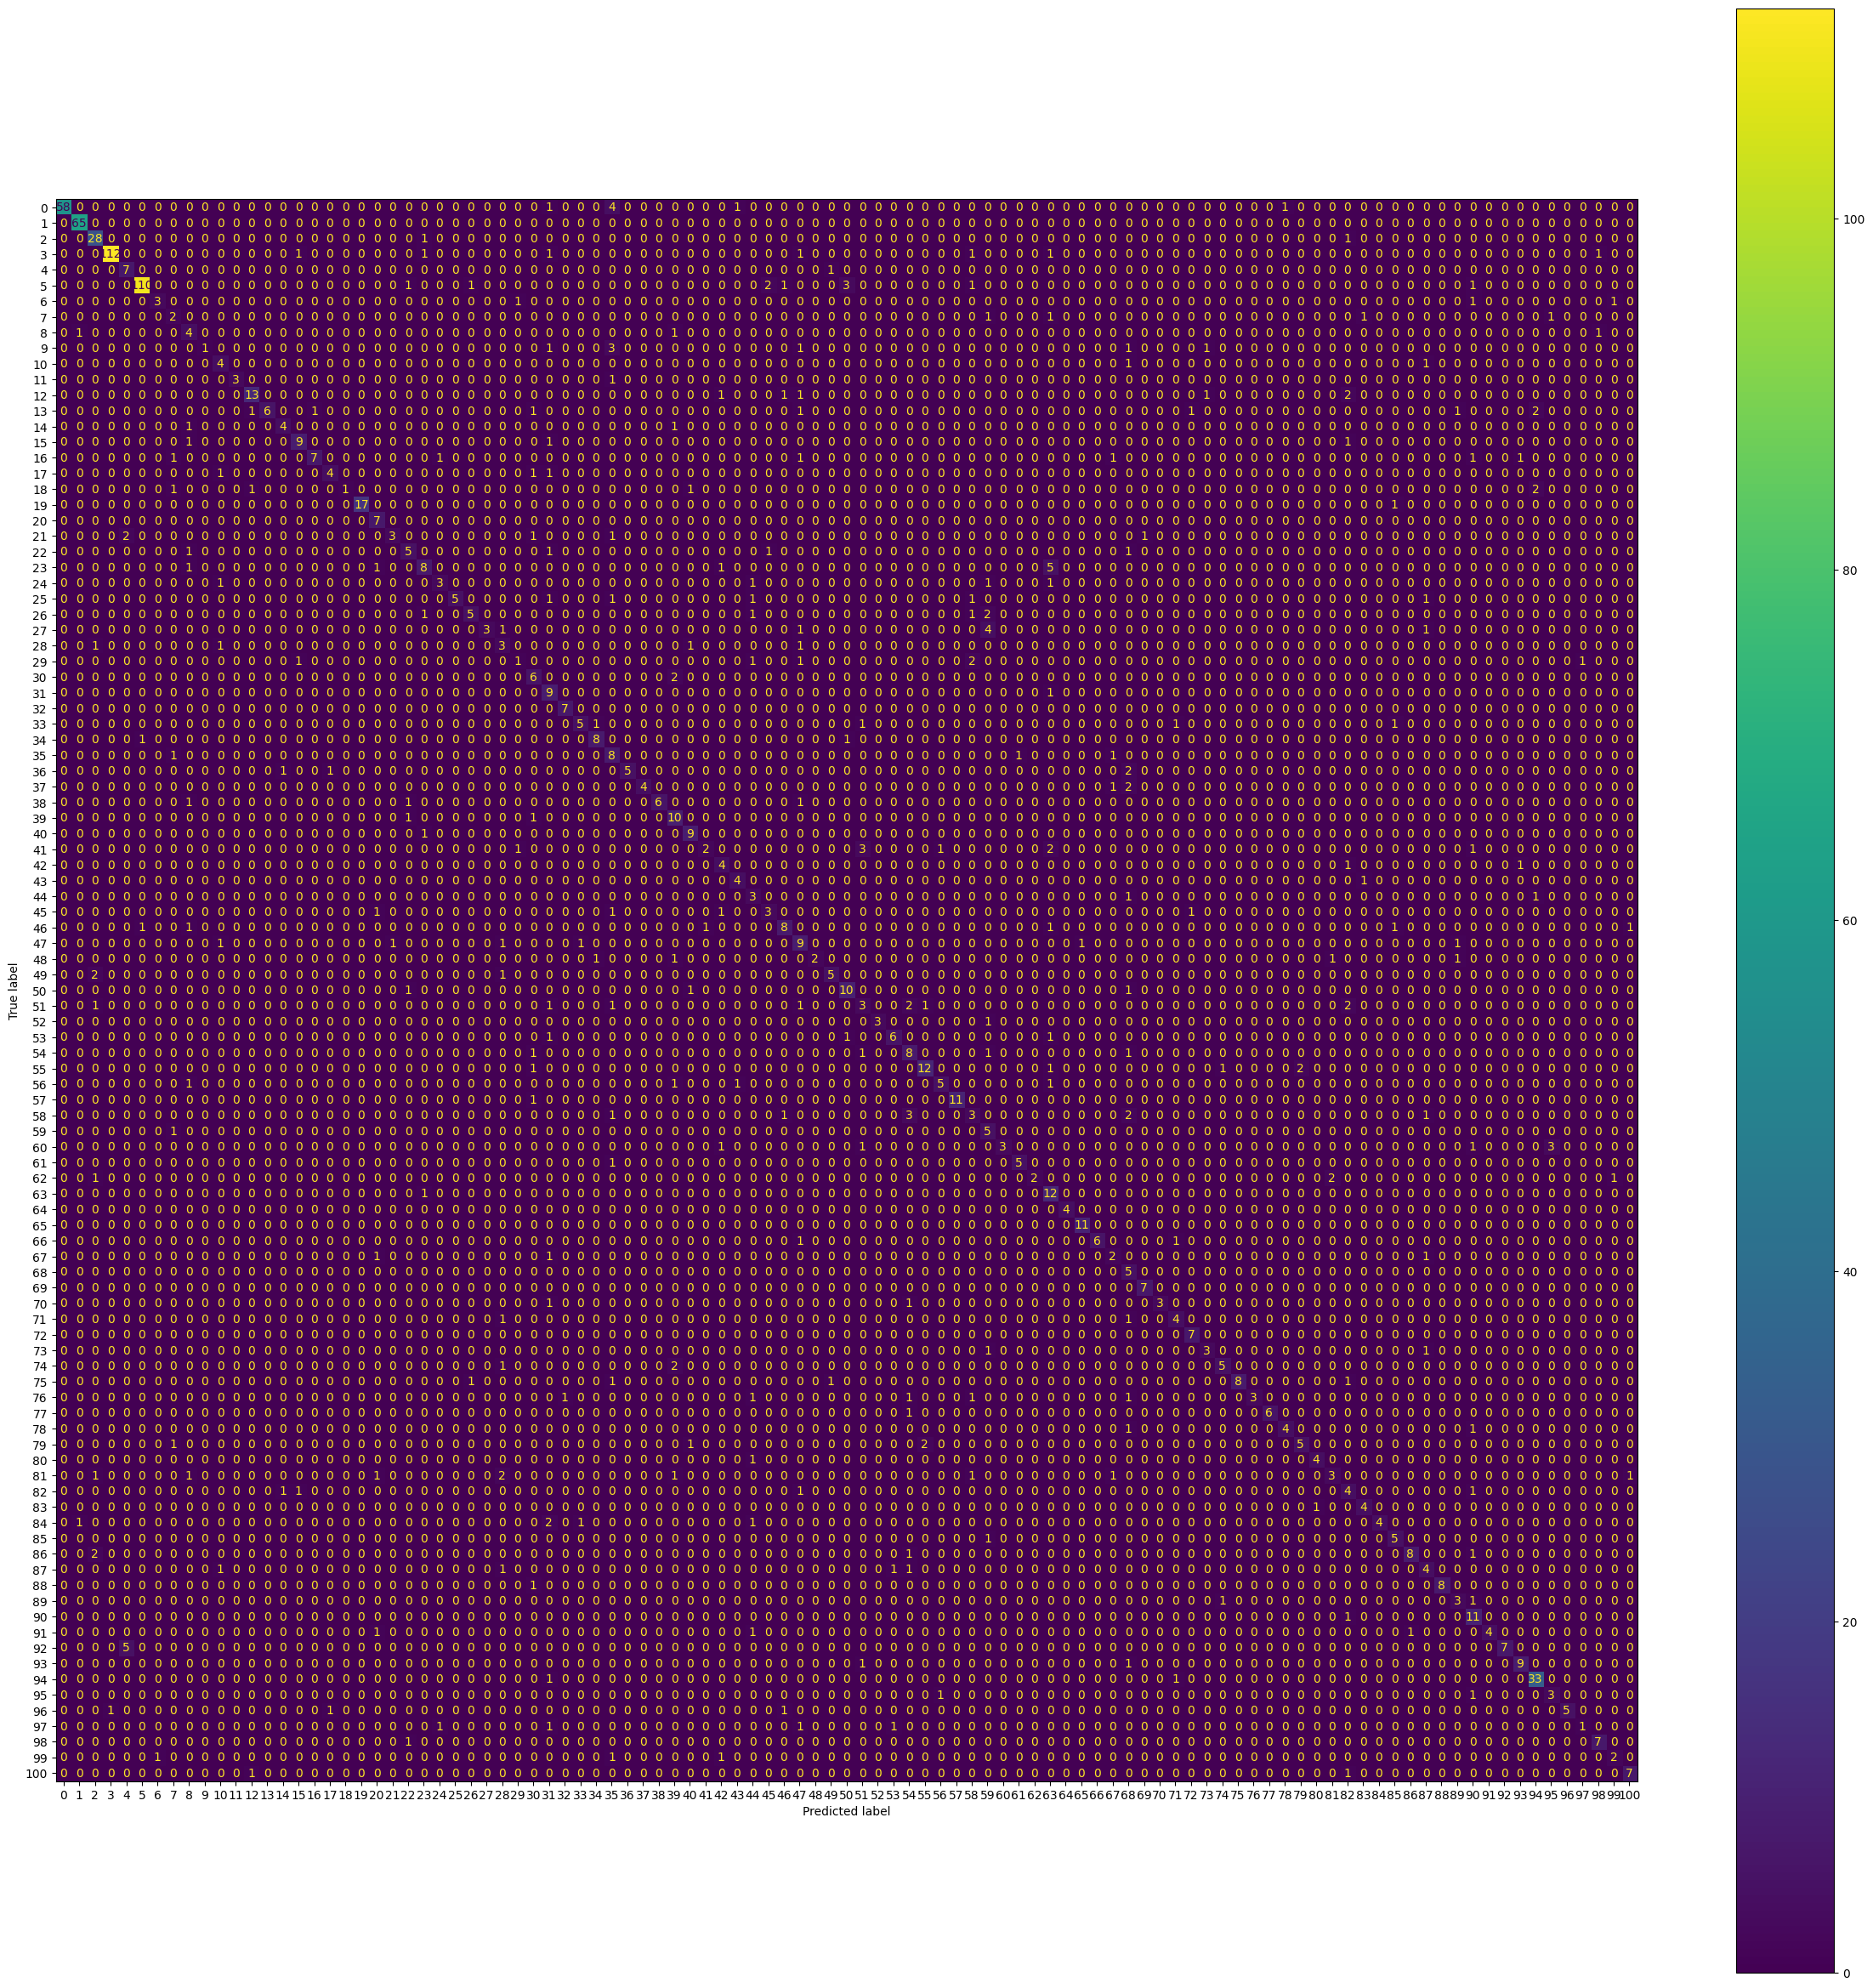

In [ ]:
model.to(device)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

_, true_labels, pred_labels = final_test()

cm = confusion_matrix(true_labels, pred_labels)

cmp = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(30,30))
cmp.plot(ax=ax)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

unique_labels = np.unique(true_labels)
count_and_accuracy = {}

less_than_10_accuracy = []
greater_than_10_accuracy = []

for label in unique_labels:
    label_indices = np.where(true_labels == label)[0]
    label_count = len(label_indices)
    label_accuracy = accuracy_score(true_labels[label_indices], pred_labels[label_indices])

    count_and_accuracy[label] = {
        'count': label_count,
        'accuracy': label_accuracy
    }

    if label_count < 20:
        less_than_10_accuracy.append(label_accuracy)
    else:
        greater_than_10_accuracy.append(label_accuracy)

# 输出每个类别的数量和准确率
for label, info in count_and_accuracy.items():
    print(f"Label {label}: count = {info['count']}, accuracy = {info['accuracy']:.03f}")

# 计算并输出平均准确率
less_than_10_avg_accuracy = np.mean(less_than_10_accuracy)
greater_than_10_avg_accuracy = np.mean(greater_than_10_accuracy)

print(f"Average accuracy for classes with less than 20 samples: {less_than_10_avg_accuracy:.03f}")
print(f"Average accuracy for classes with 20 or more samples: {greater_than_10_avg_accuracy:.03f}")


Label 0: count = 65, accuracy = 0.892
Label 1: count = 65, accuracy = 1.000
Label 2: count = 30, accuracy = 0.933
Label 3: count = 119, accuracy = 0.941
Label 4: count = 8, accuracy = 0.875
Label 5: count = 120, accuracy = 0.917
Label 6: count = 6, accuracy = 0.500
Label 7: count = 6, accuracy = 0.333
Label 8: count = 7, accuracy = 0.571
Label 9: count = 8, accuracy = 0.125
Label 10: count = 6, accuracy = 0.667
Label 11: count = 4, accuracy = 0.750
Label 12: count = 19, accuracy = 0.684
Label 13: count = 14, accuracy = 0.429
Label 14: count = 6, accuracy = 0.667
Label 15: count = 12, accuracy = 0.750
Label 16: count = 13, accuracy = 0.538
Label 17: count = 7, accuracy = 0.571
Label 18: count = 6, accuracy = 0.167
Label 19: count = 18, accuracy = 0.944
Label 20: count = 7, accuracy = 1.000
Label 21: count = 8, accuracy = 0.375
Label 22: count = 9, accuracy = 0.556
Label 23: count = 16, accuracy = 0.500
Label 24: count = 7, accuracy = 0.429
Label 25: count = 10, accuracy = 0.500
Label 26